In [2]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import torch

## for bert language model
import transformers
from transformers import AutoTokenizer, AutoModel

In [3]:
''' The following shows the result of training various non-neural network models on a cleaned version of the 
Kannada set transliterated so that all comments are in the Kannada script. models are trained on an bert vectorizer'''

' The following shows the result of training various non-neural network models on a cleaned version of the \nKannada set transliterated so that all comments are in the Kannada script. models are trained on an bert vectorizer'

In [4]:
# import data
kan_train = pd.read_table("../datasets/task_a/kan_sentiment_train.tsv")
kan_dev = pd.read_table("../datasets/task_a/kan_sentiment_dev.tsv")

In [5]:
kan_train = kan_train.rename(columns={'category': 'y'})
kan_dev = kan_dev.rename(columns={'category': 'y'})

In [6]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


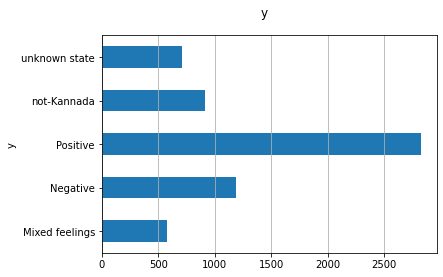

In [7]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
kan_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [8]:
# read in the list of stopwords in Kannada
with open('stopwords-kn.txt') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

lst_stopwords = lines

In [9]:
# transliterate all data from english scrip to kannada script
from indictrans import Transliterator

# instantiate the trasnliteration
trn = Transliterator(source='eng', target='kan', build_lookup=True)

# save the text column as a list in order to improve performance.
orig_kn_train = (kan_train['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans = []
for i in range(len(orig_kn_train)):
    list_trans.append(trn.transform(orig_kn_train[i]))
    
# append the transliterated texts as a column on original dataframe
kan_train['text_trans'] = list_trans

In [10]:
kan_train_trans = kan_train.drop(['text'], axis=1)
kan_train_trans.rename(columns={'text_trans':'text'}, inplace= True)
kan_train_trans

,y,text
0,Negative,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...
1,Positive,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...
2,not-Kannada,ಸುಪರ್ ಸಾರ ಸೋಂಗ್
3,Negative,ಟೀಕ್ಟೋಕರ್ಸ್ ಪ್ರಸೇಂಟ್ ಸಿತುಂಏಶನ್... ನನೋಡುವವರು ಯಾ...
4,Positive,ಸುಪರ್ ಸಾಂಗ್ ವೆರಿ ನೈಸ್....
...,...,...
6207,not-Kannada,@ಆ.ರ.ವ್ ಟುಂಬಾದ್ ತನ್ಹಾಜಿ ಅಂಧಾಧುನ ಐಸೆ ಬಹೋತ ಹೈ ...
6208,not-Kannada,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്
6209,Negative,ಬ್ರೊ...ನ್ನೀನ್ ಎಸ್ಟೆ ರೋಸ್ತ ಮದುದ್ರು...ಚೀನಾ ನೇ ಬೇ...
6210,Positive,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...


In [11]:
# do the same for the dev data
# save the text column as a list in order to improve performance.
orig_kn_dev = (kan_dev['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans_dev = []
for i in range(len(orig_kn_dev)):
    list_trans_dev.append(trn.transform(orig_kn_dev[i]))
    
# append the transliterated texts as a column on original dataframe
kan_dev['text_trans'] = list_trans_dev

In [12]:
kan_dev_trans = kan_dev.drop(['text'], axis=1)
kan_dev_trans.rename(columns={'text_trans':'text'}, inplace= True)
kan_dev_trans

,y,text
0,Mixed feelings,ಬಿಂದೂಗೇ ಸರ್ಯಗೀ ಉಗೀಥೀದೀರಾ ಗುಡ್ ಗೋ ಅಹೆಡ್ ವೇ ಅರೇ...
1,Positive,ಯೇನ ಸೋಂಗ್ ಗುರು ...ಸುಪರ್
2,not-Kannada,ಮೀ ಫೆವರತ ಸ್ಟೋರಿ
3,Positive,ಸುಪರ್ ತೋಗರಿ ತೀಪ್ಪ
4,Positive,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...
...,...,...
686,Negative,@ನಂದೀ ಪಾರ್ಥಾಸರಥೀ ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ
687,Negative,ಹುಗೀ ಗುರು ಬದೇತಾಕೆ
688,Positive,ಟ್ರೆಂಡಿಂಗ್ ನೋ.1 ವೋ
689,Positive,@ಟ್ರೋಲ್ ಸ್ತುಪಿಡ್ ಫಂಸ ನಾನು ಆದಿಕಏ ಕಾನೋ ಹೇಲ್ಥೀರೋದ...


In [13]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
:return
    cleaned text
'''
def utils_preprocess_text(text, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [14]:
#Now we can apply the preprocessing function to our data

kan_train_trans["text_clean"] = kan_train_trans["text"].apply(lambda x: 
          utils_preprocess_text(x, lst_stopwords=lst_stopwords))

kan_dev_trans["text_clean"] = kan_dev_trans["text"].apply(lambda x: 
          utils_preprocess_text(x, lst_stopwords=lst_stopwords))

In [216]:
kan_train_trans= kan_train_trans[['text_clean', 'y']]
kan_dev_trans = kan_dev_trans[['text_clean', 'y']]

In [217]:
kan_dev_trans.to_csv('kan_dev_trans_clean.tsv', sep="\t", index = False)
kan_train_trans.to_csv('kan_train_trans_clean.tsv', sep="\t", index = False)

In [53]:
# Now we can define our training data and our dev data as well as targets
train = kan_train_trans
test = kan_dev_trans

y_train = kan_train_trans['y'].values
y_test = kan_dev_trans['y'].values


# Gettint text embeddings from the bert model

In [54]:
# I'll be using the embeddings from the multilinngual bert model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = AutoModel.from_pretrained('bert-base-multilingual-uncased').to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
cls_train_list = []
cls_val_list = []

In [86]:
# tokanizing the text
#tokenized_train = tokenizer(train["text_clean"][6000:].values.tolist(), padding = 'max_length', truncation = True, return_tensors="pt", max_length=256)
tokenized_val = tokenizer(test["text_clean"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

#print(tokenized_train.keys())

#move on device (GPU)
#tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [87]:
# get the cls hidden state
with torch.no_grad():
  #hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
  hidden_val = model(**tokenized_val)

#get only the [CLS] hidden states
'''
cls_train = hidden_train.last_hidden_state[:,0,:]
cls_train = cls_train.to("cpu")
cls_train_list.append(cls_train)
del cls_train
del hidden_train
del tokenized_train

'''

cls_val = hidden_val.last_hidden_state[:,0,:]
cls_val = cls_val.to("cpu")
cls_val_list.append(cls_val)
del cls_val
del hidden_val
del tokenized_val


torch.cuda.empty_cache()

In [88]:
len(cls_val_list)

1

In [90]:
cls_val_list[0].shape


torch.Size([691, 768])

In [91]:
cls_val_list_final = []
for i in range(len(cls_val_list)):
    for j in range(len(cls_val_list[i])):
        cls_val_list_final.append(cls_val_list[i][j])

In [92]:
len(cls_val_list_final)

691

In [106]:
len(cls_train_list_final)

6212

In [108]:
type(cls_train_list_final)

list

In [128]:
X_train = torch.stack(cls_train_list_final)
X_train = pd.DataFrame(X_train)
X_test = torch.stack(cls_val_list_final)
X_test = pd.DataFrame(X_test)

y_train = kan_train_trans['y'].values
y_test = kan_dev_trans['y'].values

# Training a cat boost classifier

In [208]:
from catboost import CatBoostClassifier
classifier = CatBoostClassifier(
    iterations=70, 
    learning_rate=.5, 
    #loss_function='CrossEntropy'
)


In [209]:
## train classifier
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)

predicted_prob = classifier.predict_proba(X_test)

0:	learn: 1.3942988	total: 539ms	remaining: 37.2s
1:	learn: 1.3265240	total: 892ms	remaining: 30.3s
2:	learn: 1.2782460	total: 1.25s	remaining: 28s
3:	learn: 1.2431024	total: 1.62s	remaining: 26.7s
4:	learn: 1.2100898	total: 1.98s	remaining: 25.7s
5:	learn: 1.1901691	total: 2.33s	remaining: 24.9s
6:	learn: 1.1661307	total: 2.71s	remaining: 24.4s
7:	learn: 1.1497834	total: 3.07s	remaining: 23.8s
8:	learn: 1.1345137	total: 3.44s	remaining: 23.3s
9:	learn: 1.1212390	total: 3.8s	remaining: 22.8s
10:	learn: 1.1104832	total: 4.16s	remaining: 22.3s
11:	learn: 1.1008817	total: 4.51s	remaining: 21.8s
12:	learn: 1.0846930	total: 4.87s	remaining: 21.4s
13:	learn: 1.0722295	total: 5.23s	remaining: 20.9s
14:	learn: 1.0591695	total: 5.59s	remaining: 20.5s
15:	learn: 1.0427979	total: 5.97s	remaining: 20.1s
16:	learn: 1.0303178	total: 6.32s	remaining: 19.7s
17:	learn: 1.0204147	total: 6.68s	remaining: 19.3s
18:	learn: 1.0112855	total: 7.02s	remaining: 18.9s
19:	learn: 1.0005360	total: 7.37s	remaining:

Accuracy: 0.53
Auc: 0.74
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.27      0.12      0.16        52
      Negative       0.50      0.40      0.45       139
      Positive       0.57      0.73      0.64       321
   not-Kannada       0.57      0.52      0.54       110
 unknown state       0.27      0.17      0.21        69

      accuracy                           0.53       691
     macro avg       0.44      0.39      0.40       691
  weighted avg       0.50      0.53      0.51       691



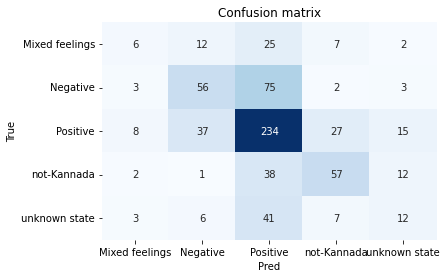

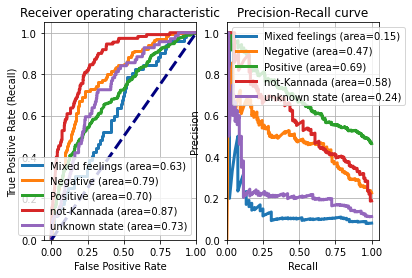

In [210]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [199]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=150, n_estimators=15, max_features=768)

In [200]:

## train classifier
classifier.fit(X_train, y_train)
## test
predicted = classifier.predict(X_test)
predicted_prob = classifier.predict_proba(X_test)

Accuracy: 0.53
Auc: 0.72
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.33      0.13      0.19        52
      Negative       0.50      0.45      0.48       139
      Positive       0.58      0.74      0.65       321
   not-Kannada       0.53      0.47      0.50       110
 unknown state       0.22      0.10      0.14        69

      accuracy                           0.53       691
     macro avg       0.43      0.38      0.39       691
  weighted avg       0.50      0.53      0.51       691



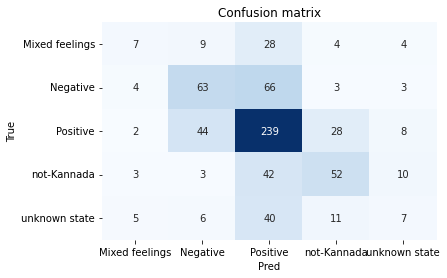

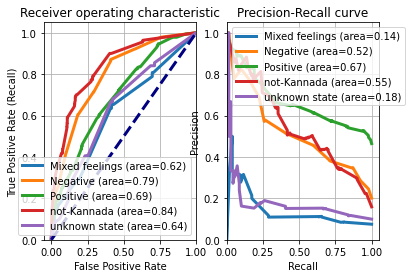

In [201]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [160]:
from sklearn.linear_model import LogisticRegression
classifier =LogisticRegression(random_state=0, max_iter= 100)

In [161]:
## pipeline

## train classifier
classifier.fit(X_train, y_train)
## test
predicted = classifier.predict(X_test)
predicted_prob = classifier.predict_proba(X_test)

/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.57
Auc: 0.79
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.00      0.00      0.00        52
      Negative       0.56      0.47      0.51       139
      Positive       0.59      0.81      0.68       321
   not-Kannada       0.60      0.50      0.54       110
 unknown state       0.30      0.19      0.23        69

      accuracy                           0.57       691
     macro avg       0.41      0.39      0.39       691
  weighted avg       0.51      0.57      0.53       691



/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


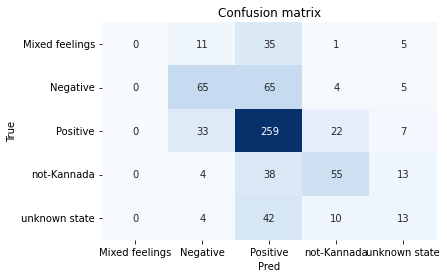

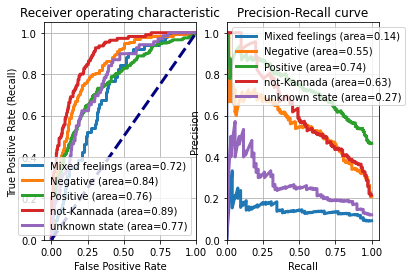

In [162]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [181]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [182]:

## train classifier
classifier.fit(X_train, y_train)
## test
predicted = classifier.predict(X_test)
predicted_prob = classifier.predict_proba(X_test)

Accuracy: 0.54
Auc: 0.69
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.17      0.13      0.15        52
      Negative       0.56      0.46      0.51       139
      Positive       0.61      0.70      0.65       321
   not-Kannada       0.55      0.52      0.54       110
 unknown state       0.31      0.29      0.30        69

      accuracy                           0.54       691
     macro avg       0.44      0.42      0.43       691
  weighted avg       0.53      0.54      0.53       691



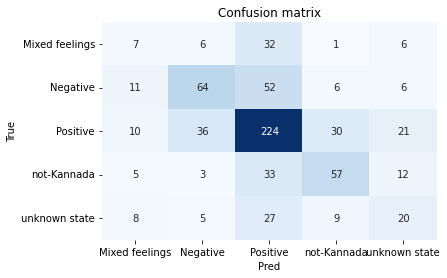

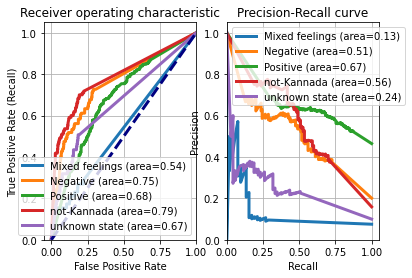

In [183]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()